### Demo to perform enrichment on DO terms

Here we can see the code to generate the enrichment with do terms

In [2]:
import json
import gzip
import copy
import re
import requests
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import fisher_exact
from wordcloud import WordCloud

### 1. Define basic datasets

After defining the GO datasets we are ready to create the other dataset (architetures, proteins and string).

In [3]:
DO_ID_PATH_OBO = 'data/do/doid.obo.txt'
PUBMED_PATH = 'data/do/human_pubmed.tab'
UNI2DO_PATH = 'data/do/uniprot_do.json'
RESULT_PATH = 'data/results/ensemble.tsv'

OUT_DO = 'data/do/do.csv'
OUT_DO_ORIGINAL = 'data/do/do_original.csv'

#### 1.1) Helping functions

In [4]:
### Return the dictionary { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
### ALSO USED FOR ONTOLOGY
def get_ontology(DO_ID_PATH_OBO):
    # Parse the disease ontology
    do = {}  # { do_id : do_object }
    obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
    with open(DO_ID_PATH_OBO) as f:
        for line in f:
            line = line.strip().split(": ")

            if line and len(line) == 2:
                k, v = line
                if k == "id" and v.startswith("DOID:"):
                    obj["id"] = v.split(":")[1]
                elif k == 'def':
                    obj['descr'] = v.split('"')[1] 
                elif k == "xref" and "OMIM" in v:
                    obj["omim"] = v.split(":")[1]
                elif k == "name":
                    obj["name"] = v
                elif k == "is_a":
                    obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
                elif k == "is_obsolete":
                    obj["is_obsolete"] = True
            else:
                if obj.get("id") and not obj.get("is_obsolete"):
                    do[obj["id"]] = obj
                obj = {}
    return do

### Return a dictionary of type {entry_ac: list of do_id}
def get_disease(DO_ID_PATH_OBO, PUBMED_PATH):
    
    # Load the do network and the pubmed file
    do = get_do_network(DO_ID_PATH_OBO)
    pubmed = pd.read_table(PUBMED_PATH, sep = '\t', dtype=str) 
    name_do = {}
    for k, v in do.items():
        name_do.setdefault(v['name'], k)

    uniprot_pmid = {}
    for n, i in enumerate(pubmed['PubMed ID'][pubmed['PubMed ID'].isna() == False].values):
        ids = i.strip().split('; ')
        for key in ids:
            uniprot_pmid.setdefault(key, []).append(pubmed.loc[n, 'Entry'])

    pmids = list(uniprot_pmid.keys())
    diseases = {}  # { uniprot_id : list_of_diseases }
    URL = "https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds"
    for i in tqdm(range(0, len(pmids), 8)):
        params = {"articleIds": ",".join(["MED:{}".format(pmid) for pmid in pmids[i:min(i + 8, len(pmids))]]), "type": "Diseases",
                  "section"   : "Abstract", "format": "JSON"}
        r = requests.get(URL, params=params)
        obj = json.loads(r.text)
        for ele in obj:
            for annotation in ele.get("annotations"):
                for uniprot_id in uniprot_pmid[ele["extId"]]:
                    if annotation["exact"] in name_do.keys():
                        DOID = name_do[annotation["exact"]]
                        diseases.setdefault(uniprot_id, set()).add(DOID)
    diseases = {k: list(v) for k, v in diseases.items()}
    return diseases

#### 1.2) DO human network viewed as dataset

In [6]:
do_human = pd.DataFrame(get_ontology(DO_ID_PATH_OBO)).transpose()
do_human.head()

,id,name,descr,is_a,omim
0001816,0001816,angiosarcoma,A vascular cancer that derives_from the cells ...,[175],NaN
0002116,0002116,pterygium,A corneal disease that is characterized by a t...,[10124],NaN
0014667,0014667,disease of metabolism,A disease that involving errors in metabolic p...,[4],NaN
0040001,0040001,shrimp allergy,A crustacean allergy that has_allergic_trigger...,[0060524],NaN
0040002,0040002,aspirin allergy,A drug allergy that has_allergic_trigger acety...,[0060500],NaN


#### 1.3) The pubmed dataset

In [7]:
pubmed = pd.read_table(PUBMED_PATH, sep = '\t', dtype=str) 
pubmed.head()

,Entry,Entry name,PubMed ID
0,Q96IY4,CBPB2_HUMAN,1939207; 14702039; 15057823; 15489334; 1057498...
1,P22362,CCL1_HUMAN,2809212; 2212659; 14702039; 15489334; 15340161...
2,Q8NCR9,CLRN3_HUMAN,17974005; 15164054; 15489334; 23033978
3,Q8IUK8,CBLN2_HUMAN,14702039; 12975309; 15489334
4,Q9BX69,CARD6_HUMAN,15489334; 22814378; 23186163


#### 1.4) Creation of the basic background for DO. 
We used the output of get_disease function to create the base line background datset. We don't run the funcctions since it launcehs more than 10000 queries and it takes almost an hour

In [8]:
### This file has all the entry_ac of uniprot, not only human proteome accession entries
with open(UNI2DO_PATH) as file:
    do_all_dict = json.load(file)

do_all = []
for key in do_all_dict.keys():
    for ids in do_all_dict[key]:
        do_all.append([key, ids])
do_all = pd.DataFrame(do_all, columns=['entry_ac', 'do_id'])
do_all.sort_values(by=['entry_ac', 'do_id']).head()

,entry_ac,do_id
21824,A0A075B6H7,0050460
21822,A0A075B6H7,0060058
21825,A0A075B6H7,0080322
21821,A0A075B6H7,1240
21823,A0A075B6H7,12858


In [9]:
### BACKGROUND DATASET
# Create
do_human_dataset = pd.merge(left=do_all, right=do_human, how='inner', left_on='do_id', right_on='id').iloc[:, [0, 1, 3, 4]]
# Save
do_human_dataset.to_csv(OUT_DO, sep='\t')
# Load
do_human_dataset = pd.read_table(OUT_DO, dtype=str, index_col=[0])
# Display INFO
print('Shape of the entire Human Disease Ontology: {}'.format(do_human_dataset.shape[0]))
do_human_dataset.sort_values(by=['entry_ac', 'do_id']).head()

Shape of the entire Human Disease Ontology: 49311


,entry_ac,do_id,name,descr
38599,A0A075B6H7,0050460,Wolf-Hirschhorn syndrome,A chromosomal deletion syndrome that is charac...
21442,A0A075B6H7,0060058,lymphoma,A hematologic cancer that affects lymphocytes ...
24090,A0A075B6H7,0080322,polycystic kidney disease,NaN
19851,A0A075B6H7,1240,leukemia,A cancer that affects the blood or bone marrow...
35045,A0A075B6H7,12858,Huntington's disease,A neurodegenerative disease that has_material_...


#### 1.5) Create of basic target dataset

In [10]:
### TARGET DATASET
# Create
original_dataset = pd.read_table(RESULT_PATH)
do_original_dataset = do_human_dataset[do_human_dataset.entry_ac.isin(original_dataset.entry_ac)]
# Save
do_original_dataset.to_csv(OUT_DO_ORIGINAL, sep='\t')
# Load
do_original_dataset = pd.read_table(OUT_DO_ORIGINAL, dtype=str, index_col=[0])
# Display INFO
print('Shape of the entire Human Disease Ontology: {}'.format(do_original_dataset.shape[0]))
do_original_dataset.sort_values(by=['entry_ac', 'do_id']).head()

Shape of the entire Human Disease Ontology: 185


,entry_ac,do_id,name,descr
36553,O00213,10652,Alzheimer's disease,A tauopathy that is characterized by memory la...
16395,O00213,1307,dementia,A cognitive disorder resulting from a loss of ...
6932,O00213,162,cancer,A disease of cellular proliferation that is ma...
23289,O00308,0080322,polycystic kidney disease,NaN
13521,O00308,10763,hypertension,An artery disease characterized by chronic ele...


### 2. Ontology dataset

In [11]:
### REQUIRES
DO_ID_PATH_OBO = 'data/do/doid.obo.txt'
OUT_ONTOLOGY_PATH = 'data/do/do_ontology.csv'

In [12]:
# Call the ontology
ontology = pd.DataFrame(get_ontology(DO_ID_PATH_OBO)).transpose()
# Duplicate the index column assinging it the name 'do_id'
ontology.insert(loc=0, column='do_id', value=ontology.index)
ontology.drop(['id'], axis=1, inplace=True)
# Set to None the roots' parent id
ontology.is_a[ontology.is_a.isna()] = None
# Format 'is_a' column converting it in a string of DO ids separated by a semicolumn
def f(x):
    if type(x) == list:
        return '; '.join(x)
    else:
        return x
ontology.is_a = ontology.is_a.map(f)
# Save
ontology.to_csv(OUT_ONTOLOGY_PATH, sep='\t')
# Load 
ontology = pd.read_csv(OUT_ONTOLOGY_PATH, sep='\t', index_col=[0], dtype=str)
# Display
ontology.head()

,do_id,name,descr,is_a,omim
1816,0001816,angiosarcoma,A vascular cancer that derives_from the cells ...,175,NaN
2116,0002116,pterygium,A corneal disease that is characterized by a t...,10124,NaN
14667,0014667,disease of metabolism,A disease that involving errors in metabolic p...,4,NaN
40001,0040001,shrimp allergy,A crustacean allergy that has_allergic_trigger...,0060524,NaN
40002,0040002,aspirin allergy,A drug allergy that has_allergic_trigger acety...,0060500,NaN


### 3. ENRICHMENT

Since we have already the datset (look at GO_demo), we go ahead and try to perfrom DO enrichment on those datasets.

In [13]:
### REQUIRES
OUT_ONTOLOGY_PATH = 'data/do/do_ontology.csv'

#### 3.1) Define helping functions

In [14]:
"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents. 
"""
def get_parents(ontology):
    # Mask used to filter roots
    not_a_root = (ontology.is_a.isna() == False)
    # Convert the 'is_a' field in a list of string and return a dict out of the dataframe
    return ontology.is_a[not_a_root].map(lambda x: x.split('; ')).to_dict()


"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.  
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    return ontology['name'].to_dict()


"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors



"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}  
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children



"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Define the nodes list
    nodes = ontology.do_id.values
    # Define the dict that associates to each DO its parents
    parents = get_parents_int(ontology)
    # Identify nodes with no predecessors
    roots = set([int(n) for n in ontology.do_id.values]) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(int(node))
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
            #print(node_parents)
        depth[node] = c
    return depth



def get_parents_int(ontology):
    # Filter roots
    df = ontology[ontology.is_a.isna() == False]
    # Convert the 'is_a' field in a list of integers
    is_a_int = df.is_a.map(lambda x: [int(n) for n in x.split('; ')])
    # Return a dict having do_id as keys and is_a as values
    return dict(zip(df.index, is_a_int))


"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05), 
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_id = 'do_id'):
    
    # Inint dict
    results = {}
    
    # Get the number of occurrances of the GO counts
    dict1, dict2 = dict(df1[col_id].value_counts()), dict(df2[col_id].value_counts())
    
    # Compute the intersaction of the GO terms
    key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))
    
    for key in key_intersection:
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1   
        tp = dict1[key]
        # Number of occurrences of the specific GO term in DF2
        tn = dict2[key]
        # Number of GO terms that are different from the specific one in DF1
        fp = sum(dict1.values()) - tp
        # Number of GO terms that are different from the specific one in DF2
        fn = sum(dict2.values()) - tn
        # 2. Perform Fisher Exact Test
        fisher_results = fisher_exact([[tp, tn],[fp, fn]])
        # 3. Save results
        results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})
    
    # Return the DataFrame
    return pd.DataFrame(results).transpose()



"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children. 
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children 
    for go_id in enrichment.index:
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment
        
    

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_id = 'do_id', col_name='name'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_id=col_id)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 4. Update dataframe
    labels_, depth_ = [], []
    for go_id in df.index:
        labels_.append(ontology[col_name][ontology[col_id] == go_id].values[0])
        depth_.append(depth[go_id])
    df['depth'] = depth_
    df[col_name] = labels_
    # 5. Return dataframe 
    return df



"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] <= max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter



"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value  
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
           row[col_name]: row[col_score] for i, row in df.iterrows()})

In [15]:
def enrichment_pipeline(DO_ONTOLOGY_PATH, TARGET_PATH, BACKGROUND_PATH, max_depth, max_pvalue, col_name='name', col_id='do_id'):
    ### 1. Load the required files
    # Ontology
    ontology = pd.read_csv(OUT_ONTOLOGY_PATH, sep='\t', index_col=[0], dtype=str)
    
    # DF1 and DF2
    original_go= pd.read_table(TARGET_PATH,
                               dtype={'entry_ac': str,
                                      col_id: str,
                                      col_name: str})

    background_go= pd.read_table(BACKGROUND_PATH,
                                 dtype={'entry_ac': str,
                                        col_id: str,
                                        col_name: str})

    ### 2. Compute the enrichness
    enrich_result = enrich(df1=original_go,
                           df2=background_go,
                           ontology=ontology,
                           col_name=col_name,
                           col_id=col_id)

    ### 3. Filter the results and create the WordCloud
    # Results
    if ((enrich_result['p-value'] > max_pvalue) | (enrich_result['depth'] > max_depth)).all():
        warnings.warn('No object passed the filter. Returning non-filtered dataset')
        enrich_result['score'] = np.zeros((1, enrich_result.shape[0])).reshape(-1) - 1
        return enrich_result, None
    enrich_result = enrich_filter(df = enrich_result, max_depth=max_depth, max_pvalue=max_pvalue)
    # WordCloud.
    word_cloud_img = word_cloud(df=enrich_result, col_name=col_name, col_score='score')

    return enrich_result, word_cloud_img

#### 5.2) Enrichment: Original vs Human

Perform enrichment of first dataset. Output results are not saved, just displayed

C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OddRatio,p-value,depth,name,score
8566,0.150548,0.038810,3,herpes simplex,3.249089
14731,0.022391,0.025874,2,Weaver syndrome,3.654527
14748,0.022391,0.025874,5,Sotos syndrome,3.654527
305,0.268620,0.025254,4,carcinoma,3.678766
0060041,0.113330,0.023376,4,autism spectrum disorder,3.756064


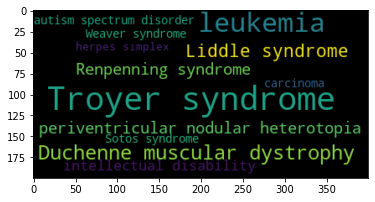

In [16]:
### REQUIRES
DO_ONTOLOGY_PATH = 'data/do/do_ontology.csv'
TARGET_PATH = 'data/do/do.csv' # Dataset of all human protein with primal key (uniprot_id, do_id)
BACKGROUND_PATH = 'data/do/do_original.csv' #Dataset of 'original' proteins with primal key (uniprot_id,do_id)

### Params
col_id = 'do_id'
col_name = 'name'
max_pvalue = 0.05
max_depth = 5

### Pipeline
results, word_cloud_img = enrichment_pipeline(DO_ONTOLOGY_PATH=DO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth, 
                                              col_name=col_name, 
                                              col_id=col_id)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.3) Enrichment: Original PDB + proteins with same PDB vs Human proteins with PDB

In [17]:
### REQUIRES
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/do/do.csv'
MAPPING_FILE_PATH = 'data/pdb_data/pdb_chain_uniprot.tsv'
HUMAN_UNIPROT_PATH = 'data/human.csv'

OUT_BACKGROUND_PDB_PATH = 'data/pdb_data/pdb_background_do.csv'
OUT_TARGET_PDB_DATASETS_PATH = 'data/pdb_data/pdb_target_do.csv'

"""
Functions that create the datasets (target and background) for PDB network
"""
def pdb_target_dataset(original_dataset_path, go_dataset_path,
                       mapping_dataset_path, human_dataset_path,
                       col_name_entry = 'entry_ac', col_name_pdb = 'pdb_ids'):

    """
    1. original_dataset_path: the path of the target dataset, a.k.a the dataset of protein tha passed our model
    2. go_dataset_path: the path of the full go dataset (entry_ac, go_id)
    3. mapping_dataset_path: the path of the file mapping from pdb to uniprot
    4. human_dataset_path: the path of the full human dataset
    5. col_name_entry: the name of the column containing the proteins uniprot id
    6. col_name_pdb: the name of the column containing the proteins pdb id
    """

    ### 1. Load the mapping
    mapping_df = pd.read_table(mapping_dataset_path, header=1)
    mapping_df.columns = [col.lower() for col in mapping_df.columns]
    ### 2. Load the original dataset
    original_df = pd.read_table(original_dataset_path)
    ### 3. Load the go dataset
    background_df = pd.read_table(go_dataset_path, dtype=str, index_col=[0])
    ### 4. Load the human dataset
    human_df = pd.read_table(human_dataset_path)
    # 4.1 Take out the entry_ac that have a pdb_id
    protein_with_pdb = human_df.entry_ac[human_df[col_name_pdb].isna() == False]
    # 4.2 Take out from  the background dataset the protein without a pdb
    background_df = background_df[background_df[col_name_entry].isin(protein_with_pdb)]
    ### 5. Get all original proteins with a pdb and get all the other proteins which shares the same pdb
    # 5.1. Get a dataset with key (uniprot_id, pdb_id)
    values = []
    for n in range(original_df.shape[1]):
        key = original_df.loc[n, col_name_entry]
        value = original_df.loc[n, col_name_pdb]
        if type(value) == str:
            pdb_ids = value.split(';')[:-1]
            for ids in pdb_ids:
                values.append([key, ids.lower()])
    pdb_original = pd.DataFrame(values, columns=[col_name_entry, col_name_pdb])
    # 5.2 Merge the new dataset with the mapping df to get all the proteins with that pdb id
    target_dataset = pd.merge(pdb_original, mapping_df, left_on=col_name_pdb, right_on='pdb', how='left')
    ### 6. Get the GO of every pdb_in our target_dataset
    target_dataset = background_df[background_df[col_name_entry].isin(target_dataset['sp_primary'])]
    ###

    return target_dataset, background_df

target_pdb, background_pdb = pdb_target_dataset(original_dataset_path=RESULTS_PATH, 
                                                go_dataset_path=GO_PATH, 
                                                mapping_dataset_path=MAPPING_FILE_PATH, 
                                                human_dataset_path=HUMAN_UNIPROT_PATH)

target_pdb.to_csv(OUT_TARGET_PDB_DATASETS_PATH, sep='\t')
background_pdb.to_csv(OUT_BACKGROUND_PDB_PATH, sep='\t')
target_pdb.head()

,entry_ac,do_id,name,descr
3038,Q9HAU0,162,cancer,A disease of cellular proliferation that is ma...
3185,Q9GZV5,162,cancer,A disease of cellular proliferation that is ma...
3714,Q9HCE7,162,cancer,A disease of cellular proliferation that is ma...
3906,Q9BYW2,162,cancer,A disease of cellular proliferation that is ma...
4820,P31947,162,cancer,A disease of cellular proliferation that is ma...


C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OddRatio,p-value,depth,name,score
263,22.460452,0.046594,4,kidney cancer,3.066277
10933,36.764253,0.029682,4,obsessive-compulsive disorder,3.517221
14731,67.415254,0.017421,2,Weaver syndrome,4.050069
1826,6.106037,0.015208,5,epilepsy,4.185940
1793,13.684483,0.010614,4,pancreatic cancer,4.545612


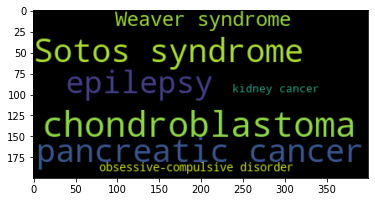

In [18]:
### REQUIRES
DO_ONTOLOGY_PATH = 'data/do/do_ontology.csv'
TARGET_PATH = 'data/pdb_data/pdb_target_do.csv' 
BACKGROUND_PATH = 'data/pdb_data/pdb_background_do.csv'

### Params
#col_name_go_id = 'go_id'
#col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 5

### Pipeline
results, word_cloud_img = enrichment_pipeline(DO_ONTOLOGY_PATH=DO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.4) Enrichment: One specific architecture vs All architecture

In [21]:
## REQUIRES 
HUMAN_UNIPROT_PATH = 'data/human.csv'
RESULTS_PATH = 'data/results/ensemble.tsv'
DO_PATH = 'data/do/do.csv'

OUT_BACKGROUND_ARCHITECTURE_PATH = 'data/architecture2/do_architectures/architecture_background.csv'
OUT_TARGET_ARCHITECTURE_DATASETS_PATH = 'data/architecture2/do_architectures/'

We first create the background dataset (the original one) 

In [22]:
do_dataset = pd.read_csv(DO_PATH, sep='\t', dtype=str, index_col=[0])
human_dataset = pd.read_csv(HUMAN_UNIPROT_PATH, sep='\t')
original_dataset = pd.read_csv(RESULTS_PATH, sep='\t')

# Select sets of domain families
architectures = [set(x.split(';')[:-1]) for x in original_dataset["pfam_ids"][original_dataset['pfam_ids'].isna() == False]]
# Sort architecture sets and convert them in strings
architectures = [';'.join(sorted(list(x))) for x in architectures]

# Create a new dataframe mapping each protein to its domain architecture
background_architecture = pd.DataFrame(list(zip(original_dataset['entry_ac'], architectures)), 
                                       columns=('entry_ac', 'architecture'), dtype=str)
# Save the dataframe
background_architecture = pd.merge(do_dataset, background_architecture)
background_architecture.to_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t')
background_architecture.head()

,entry_ac,do_id,name,descr,architecture
0,O75554,768,retinoblastoma,A retinal cell cancer and malignant neoplasm o...,PF00397;PF06220
1,O75554,162,cancer,A disease of cellular proliferation that is ma...,PF00397;PF06220
2,O75554,3312,bipolar disorder,A mood disorder that involves alternating peri...,PF00397;PF06220
3,O75554,5419,schizophrenia,A psychotic disorder that is characterized by ...,PF00397;PF06220
4,Q9BTA9,162,cancer,A disease of cellular proliferation that is ma...,PF00397


Secondly, we create all the target datasets (splitted by architecture sequence) 

In [23]:
"""
Function that extract the proteins belonging to a certain architecture and maps each protein to its
GO annotation. Accept in input the architecture of interest and two dataframes. The first one maps e
very protein to its architecture and requires columns 'entry_ac' and 'architecture', the second one
requires columns 'entry_ac' and 'do'.
"""
def select_architecture(arch, arch_df, do_df):
    assert arch in arch_df.architecture.values, 'Architecture not found'
    assert set(arch_df.entry_ac).issubset(set(do_df.entry_ac)), 'Architecture entries do not match'

    # 1. Select proteins that present the input architecture
    entries = arch_df.entry_ac[arch_df.architecture == arch]
    # 2. Retrieve DO for each protein
    return do_df.loc[do_df.entry_ac.isin(entries)]



"""
Loops over the architectures observed in 'original_arch' and apply 'select_architecture' to
each of them saving the outputs in BASE_PATH folder.
"""
# Load file that maps each protein to its architecture
original_arch = pd.read_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t', index_col=0)
# Load file that maps each protein to its DO annotations
ds_gene_ontology = pd.read_csv(DO_PATH, sep='\t', dtype=str, index_col=[0])

# List all the observed architectures
arch_list = list(set(original_arch.architecture))

# Save tsv files for each architecture
for arch in arch_list:
    go_arch_df = select_architecture(arch=arch, arch_df=original_arch, do_df=ds_gene_ontology)
    go_arch_df.to_csv(OUT_TARGET_ARCHITECTURE_DATASETS_PATH+arch+'_arch.csv', sep='\t')
    
# Print last target architecture_dataset
go_arch_df.head()

,entry_ac,do_id,name,descr
10539,Q6ZUM4,162,cancer,A disease of cellular proliferation that is ma...
17452,Q6ZUM4,1793,pancreatic cancer,An endocrine gland cancer located_in the pancr...
26647,Q6ZUM4,1040,chronic lymphocytic leukemia,A lymphoblastic leukemia characterized by over...
28351,Q6ZUM4,1324,lung cancer,A respiratory system cancer that is located_in...


In [24]:
### REQUIRES
DO_ONTOLOGY_PATH = 'data/do/do_ontology.csv'
TARGET_PATH = 'data/architecture2/do_architectures/PF00397_arch.csv' 
BACKGROUND_PATH = 'data/architecture2/do_architectures/architecture_background.csv'
### Params
#col_name_go_id = 'go_id'
#col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 5

### Pipeline
results, word_cloud_img = enrichment_pipeline(DO_ONTOLOGY_PATH=DO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
if word_cloud_img:
    fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: No object passed the filter. Returning non-filtered dataset


,OddRatio,p-value,depth,name,score
12858,2.586466,0.240972,5,Huntington's disease,-1.0
1240,1.870588,0.290200,4,leukemia,-1.0
10017,8.900000,0.199447,5,multiple endocrine neoplasia type 1,-1.0
1059,3.035088,0.199784,4,intellectual disability,-1.0
0080322,2.187500,0.429144,5,polycystic kidney disease,-1.0
